# Predicting the probability of a UK Parliamentary constituency voting for the Conservative Party

## Environment Setup

In [134]:
# Import Libraries
from logging import warning
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Surpress warnings
warnings.filterwarnings("ignore")

# Read csv
dataset = pd.read_csv("combined-dataset-england-only.csv")


## Model Summary Class

Python class provided in class which summarises a created sklearn model

In [135]:
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

class ModelSummary:
    """ This class extracts a summary of the model
    
    Methods
    -------
    get_se()
        computes standard error
    get_ci(SE_est)
        computes confidence intervals
    get_pvals()
        computes p-values
    get_summary(name=None)
        prints the summary of the model
    """
    
    def __init__(self, clf, X, y):
        """
        Parameters
        ----------
        clf: class
            the classifier object model
        X: pandas Dataframe
            matrix of predictors
        y: numpy array
            matrix of variable
        """
        self.clf = clf
        self.X = X
        self.y = y
        pass
    
    def get_se(self):
        """Computes the standard error

        Returns
        -------
            numpy array of standard errors
        """
        # from here https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients
        predProbs = self.clf.predict_proba(self.X)
        X_design = np.hstack([np.ones((self.X.shape[0], 1)), self.X])
        V = np.diagflat(np.product(predProbs, axis=1))
        covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
        return np.sqrt(np.diag(covLogit))

    def get_ci(self, SE_est):
        """Computes the confidence interval

        Parameters
        ----------
        SE_est: numpy array
            matrix of standard error estimations
        
        Returns
        -------
        cis: numpy array
            matrix of confidence intervals
        """
        p = 0.975
        df = len(self.X) - 2
        crit_t_value = stats.t.ppf(p, df)
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        upper = coefs + (crit_t_value * SE_est)
        lower = coefs - (crit_t_value * SE_est)
        cis = np.zeros((len(coefs), 2))
        cis[:,0] = lower
        cis[:,1] = upper
        return cis
    
    def get_pvals(self):
        """Computes the p-value

        Returns
        -------
        p: numpy array
            matrix of p-values
        """
        # from here https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
        p = self.clf.predict_proba(self.X)
        n = len(p)
        m = len(self.clf.coef_[0]) + 1
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        se = self.get_se()
        t =  coefs/se  
        p = (1 - stats.norm.cdf(abs(t))) * 2
        return p
    
    def get_summary(self, names=None):
        """Prints the summary of the model

        Parameters
        ----------
        names: list
            list of the names of predictors
        """
        ses = self.get_se()
        cis = self.get_ci(ses)
        lower = cis[:, 0]
        upper = cis[:, 1]
        pvals = self.get_pvals()
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        data = []
        for i in range(len(coefs)):
            currlist = []
            currlist.append(np.round(coefs[i], 3))
            currlist.append(np.round(ses[i], 3))
            currlist.append(np.round(pvals[i], 3))
            currlist.append(np.round(lower[i], 3))
            currlist.append(np.round(upper[i], 3))
            data.append(currlist)
        cols = ['coefficient', 'std', 'p-value', '[0.025', '0.975]']
        sumdf = pd.DataFrame(columns=cols, data=data)
        if names is not None:
            new_names = ['intercept']*(len(names) + 1)
            new_names[1:] = [i for i in names]
            sumdf.index = new_names
        else:
            try:
                names = list(self.X.columns)
                new_names = ['intercept']*(len(names) + 1)
                new_names[1:] = [i for i in names]
                sumdf.index = new_names
            except:
                pass
        print(sumdf)
        acc = accuracy_score(self.y, self.clf.predict(self.X))
        confmat = confusion_matrix(self.y, self.clf.predict(self.X))
        print('-'*60)
        print('Confusion Matrix (total:{}) \t Accuracy: \t  {}'.format(len(self.X),np.round(acc, 3)))
        print('  TP: {} | FN: {}'.format(confmat[1][1],confmat[1][0]))
        print('  FP: {} | TN: {}'.format(confmat[0][1],confmat[0][0]))

## Split the dataset into training, validation, and testing group

In order to prevent overfitting the model must be validated and tested on data which it is not trained on. Hence we randomly split the data into 3 subgroups.

In [136]:
# Put 60% of the data into a training set and 40% into a combined testing set
dataset_train, dataset_splitdata = train_test_split(
    dataset, test_size = 0.4, random_state = 0
)

# Split the combined testing set into validation and testing sets
dataset_val, dataset_test = train_test_split(
    dataset_splitdata, test_size = 0.5, random_state = 0
)

## Balancing the dataset

In order to get a better model we want there to be an equal number of consituencies which voted Tory as those who didn't

In [137]:
# Counting num of constituencies that voted Tory and for another party
total = len(dataset_train)
num_CON = dataset_train["Binary_Con (1 = win)"].sum()
num_notCON = total - num_CON

# Adjusting dataset
dataset_voteCON = dataset_train.loc[dataset_train["Binary_Con (1 = win)"] == 1].sample(num_notCON)
dataset_votenotCON = dataset_train.loc[dataset_train["Binary_Con (1 = win)"] == 0]

resampled_dataset_train = pd.concat((dataset_voteCON, dataset_votenotCON))

## Splitting features and predictors & Data preparation
`X` and `y` values will be split into sperae variables to make later code easier.

Consitutuency names were dropped since they are strings and not relevent. Voting percentages (other than conservative) were not included since they are directly dependent on the convervative vote %. Absolute numbers were removed since per capita features were developed.

In [138]:
X_train = resampled_dataset_train.drop(columns = [
    "Binary_Con (1 = win)", "Constituency Name", "Electorate", "Number of Businesses", "Conservative Votes",
    "Conservative Vote (proportion)", "Labour Votes", "Labour Vote (proportion)", "Lib Dem Votes", "Lib Dem Vote (proportion)"
])
y_train = resampled_dataset_train["Binary_Con (1 = win)"].values.reshape(-1, 1)

X_val = dataset_val.drop(columns = [
    "Binary_Con (1 = win)", "Constituency Name", "Electorate", "Number of Businesses", "Conservative Votes",
    "Conservative Vote (proportion)", "Labour Votes", "Labour Vote (proportion)", "Lib Dem Votes", "Lib Dem Vote (proportion)"
])
y_val = dataset_val["Binary_Con (1 = win)"].values.reshape(-1, 1)

X_test = dataset_test.drop(columns = [
    "Binary_Con (1 = win)", "Constituency Name", "Electorate", "Number of Businesses", "Conservative Votes",
    "Conservative Vote (proportion)", "Labour Votes", "Labour Vote (proportion)", "Lib Dem Votes", "Lib Dem Vote (proportion)"
])
y_test = dataset_test["Binary_Con (1 = win)"].values.reshape(-1, 1)

## Seaborn Correlation Heatmap

A seaborn correleation heatmap is cretaed to see the correlations between the various features

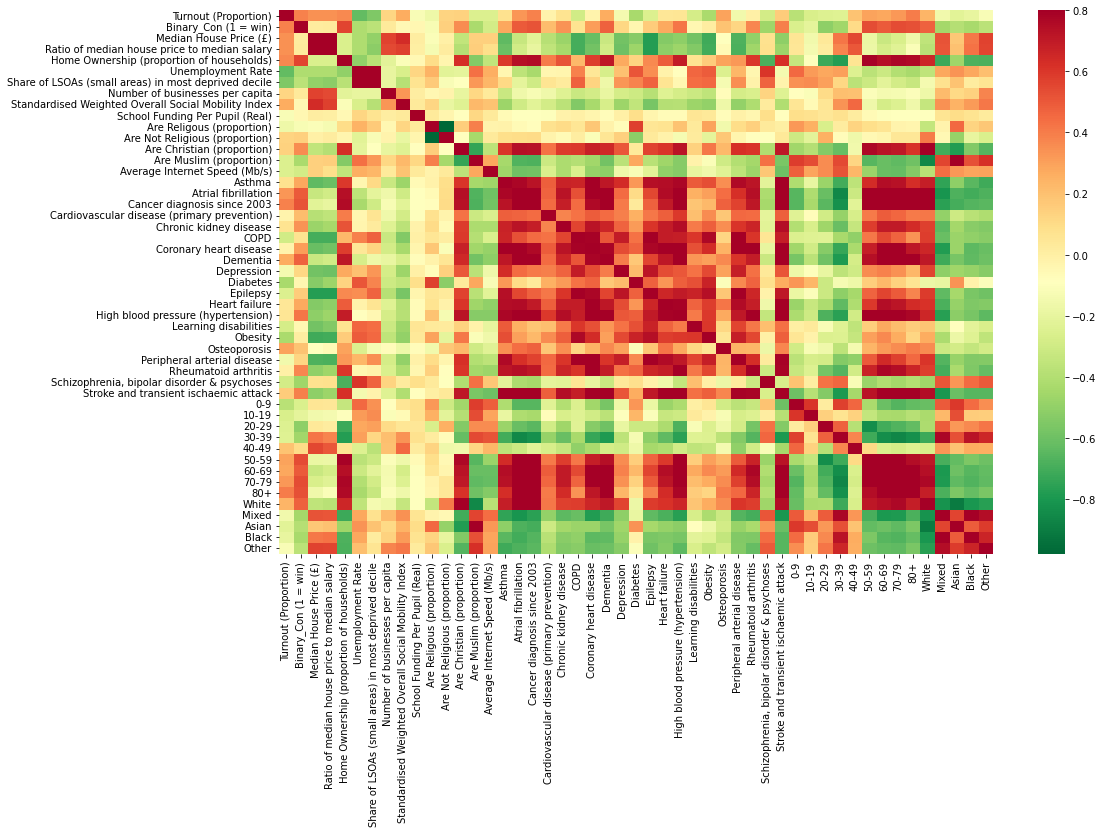

Labour Vote (proportion)                               -0.7029
Labour Votes                                           -0.6716
20-29                                                  -0.5095
Schizophrenia, bipolar disorder & psychoses            -0.4589
30-39                                                  -0.4518
Mixed                                                  -0.4458
Black                                                  -0.4356
Are Muslim (proportion)                                -0.4297
Unemployment Rate                                      -0.4164
Asian                                                  -0.3939
Other                                                  -0.3706
Share of LSOAs (small areas) in most deprived decile   -0.3705
Average Internet Speed (Mb/s)                          -0.2867
0-9                                                    -0.2608
10-19                                                  -0.2097
Are Religous (proportion)                              

In [155]:
seaborn_data = dataset.drop(columns = [
    "Constituency Name", "Electorate", "Number of Businesses", "Conservative Votes",
    "Conservative Vote (proportion)", "Labour Votes", "Labour Vote (proportion)", "Lib Dem Votes", "Lib Dem Vote (proportion)"
])

corrmat = seaborn_data.corr()
heatmap = plt.figure(figsize = (16, 10))

sns.heatmap(corrmat, vmax = 0.8, cmap = "RdYlGn_r")
plt.show()

corrT = dataset.corr(method = "pearson").round(4)
corrT = corrT.sort_values(by = ["Binary_Con (1 = win)"])
corrT["Binary_Con (1 = win)"]

# Feature Selection

A logisitcal regrerssion prediction model was established using the training data.

In order to prevent overfitting in the model, an autoatic forwards selection algorithm is used.

First a function is created to chose the next feature to be added. The feature is only added if it improves the accuracy of the model by a certain criteria

In [140]:
stopping_criteria = 0.005

def add_feature(X_train, y_train, X_val, y_val, current_features, features_to_test):
    """
    Function which adds a feature if it improves accuracy by 0.5%
    """

    # Set the next feature to be added to the model to be None
    next_feature = None

    # Convert current_features to list
    current_features = list(current_features)
    
    # If there are no current features, accuracy is 0
    if len(current_features) == 0:
        best_accuracy = 0
        
    # If there is 1 feature, it needs to be reshaped to be a nested list
    elif len(current_features) == 1:
        # make and fit logreg model
        temp_model = logreg().fit(
            X_train[current_features].values.reshape(-1, 1), y_train
        )
        # test model on validation data
        val_prediction = temp_model.predict(X_val[current_features].values.reshape(-1, 1))
        best_accuracy = accuracy_score(y_val, val_prediction)
        
    # Normal behaviour for > 1 feature
    else:
        temp_model = logreg().fit(X_train[current_features], y_train)
        val_prediction = temp_model.predict(X_val[current_features])
        best_accuracy = accuracy_score(y_val, val_prediction)
    
    # Test new features and identfies the next which increases accuracy by more than stopping_criteria
    for feature in features_to_test:
        temp_model = logreg().fit(X_train[current_features + [feature]], y_train)
        y_prediction = temp_model.predict(X_val[current_features + [feature]])
        accuracy = accuracy_score(y_val, y_prediction)
        # print(f"Feature being tested is {feature}")
        # print(f"Accuracy from test is {accuracy}")
        
        if accuracy - best_accuracy >= stopping_criteria:
            best_accuracy = accuracy
            next_feature = feature
            
    if next_feature != None:
        # Update the user on what is happening
        print(f"{next_feature} has been added to the model")
        print(f"The new validation accuracy is {best_accuracy}")
        
        # Add new feature to feature list
        new_feature_list = current_features + [next_feature]
        
    else:
        print("No features were added to the model")
        new_feature_list = current_features
        
    return new_feature_list, best_accuracy

The previous function is now run in a loop to chose the features used in the model. The number of chosen features is specified.

In [141]:
def forward_selection(X_train, y_train, X_val, y_val, max_num_features):
    """
    Function which runs the forward selection algorithm for feature selection.
    Uses the add_feature function for chosing whether/which feature to chose.
    """
    
    # Extract list of possible features
    available_features = list(X_train.columns)
    
    # Set variable defaults
    model_features = []
    model_accuracy = 0
    
    # Forward selection algorithm
    for i in range(0, max_num_features):
        model_features, best_accuracy = add_feature(X_train, y_train, X_val, y_val, model_features, available_features)
        if best_accuracy == model_accuracy:
            break
        else:
            for feature in available_features:
                if feature in model_features:
                    available_features.remove(feature)
                    
    # Print updated list of features
    # print(model_features, best_accuracy)
    return model_features, best_accuracy

This is now run

In [142]:
num_features = 5
model_features, best_accuracy = forward_selection(X_train, y_train, X_val, y_val, num_features)

20-29 has been added to the model
The new validation accuracy is 0.8317757009345794
Mixed has been added to the model
The new validation accuracy is 0.8691588785046729
No features were added to the model
No features were added to the model
No features were added to the model


## Creating the model & testing

A logistic regression model is created using the previosuly selected features.

These are then tested on the test data and a confusion matrix is generated.

In [156]:
## Make model
# Curating training & test data
final_training = X_train[model_features]
final_val = X_val[model_features]
final_test = X_test[model_features]

# Fit logreg model to data
mylr = logreg().fit(final_training, y_train)

# Model prediction with train, validation and test data
train_prediction = mylr.predict(final_training)
val_prediction = mylr.predict(final_val)
test_prediction = mylr.predict(final_test)

## Generate confusion matrix
# Training data
print("Training data\n")
conf_matrix = confusion_matrix(y_train, train_prediction, labels = [1, 0])
print(conf_matrix)

print(accuracy_score(y_train, train_prediction))
print(precision_score(y_train, train_prediction))
print(recall_score(y_train, train_prediction))

# Validation data
print("\nValidation data\n")
conf_matrix = confusion_matrix(y_val, val_prediction, labels = [1, 0])
print(conf_matrix)

print(accuracy_score(y_val, val_prediction))
print(precision_score(y_val, val_prediction))
print(recall_score(y_val, val_prediction))

# Test data
print("\nTest data\n")
conf_matrix = confusion_matrix(y_test, test_prediction, labels = [1, 0])
print(conf_matrix)

print(accuracy_score(y_test, test_prediction))
print(precision_score(y_test, test_prediction))
print(recall_score(y_test, test_prediction))

modsummary = ModelSummary(mylr, X_test[model_features], y_test)
modsummary.get_summary()


Training data

[[102  11]
 [ 52  61]]
0.7212389380530974
0.6623376623376623
0.9026548672566371

Validation data

[[64  5]
 [ 9 29]]
0.8691588785046729
0.8767123287671232
0.927536231884058

Test data

[[63  7]
 [14 23]]
0.8037383177570093
0.8181818181818182
0.9
           coefficient     std  p-value  [0.025  0.975]
intercept        0.307   0.586    0.600  -0.855   1.469
20-29           -2.172   5.137    0.672 -12.357   8.014
Mixed           -0.769  14.204    0.957 -28.933  27.396
------------------------------------------------------------
Confusion Matrix (total:107) 	 Accuracy: 	  0.804
  TP: 63 | FN: 7
  FP: 14 | TN: 23


## Graphs

Finally graphs were generated to show how the accuracy of the modle changed as more features were added, a visual way to justify feature selection.

In [144]:
# # Data calculations

# mean_accuracy_training = {
#     2: 0.6991150442477876,
#     3: 0.7212389380530974,
#     4: 
# }

# mean_accuracy_validation = {
#     2: 0.8598130841121495,
#     3: 0.8691588785046729,
# }









# # # Make graph
# # plt.figure()
# # # plt.plot(graph_df["accuracy-validation"], "r")
# # plt.plot([keys_list_val], [averaged_values_list_val], "b")
# # plt.title("Accuracy")
# # plt.xlabel("Number of features")
# # plt.ylabel("Mean Accuracy")
# # plt.legend(["Training Data", "Validation Data"])


